In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Scalable Gaussian processes in PyMC3

PyMC3 has support for [Gaussian Processes (GPs)](https://docs.pymc.io/gp.html), but this implementation is too slow for many applications in time series astrophysics.
So *exoplanet* comes with an implementation of scalable GPs powered by [celerite](https://celerite.readthedocs.io/).
More information about the algorithm can be found in the [celerite docs](https://celerite.readthedocs.io/) and in the papers ([Paper 1](https://arxiv.org/abs/1703.09710) and [Paper 2](https://arxiv.org/abs/1801.10156)), but this tutorial will give a hands on demo of how to use celerite in PyMC3.

Let's start with the quickstart demo from the [celerite docs](https://celerite.readthedocs.io/en/stable/tutorials/first/).
We'll fit the following simulated dataset using the sum of two :class:`exoplanet.gp.terms.SHOTerm` objects.

First, generate the simulated data:

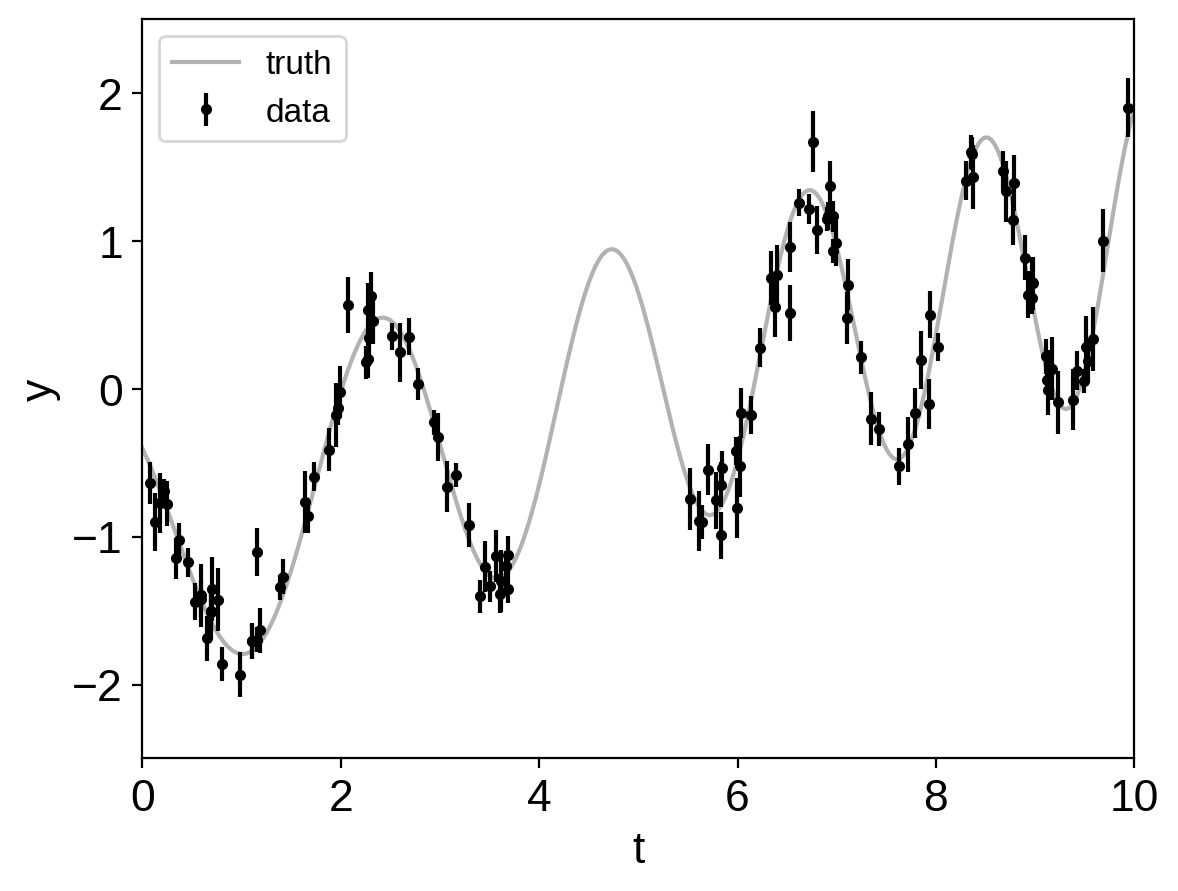

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(np.random.uniform(0, 3.8, 57), np.random.uniform(5.5, 10, 68))
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

This plot shows the simulated data as black points with error bars and
the true function is shown as a gray line.

Now let's build the PyMC3 model that we'll use to fit the data.
We can see that there's some roughly periodic signal in the data as well
as a longer term trend. To capture these two features, we will model
this as a mixture of two stochastically driven simple harmonic
oscillators (SHO) with the power spectrum:

$$
S(\omega) = \sqrt{\frac{2}{\pi}}\frac{S_1\,{\omega_1}^4}{(\omega^2 - {\omega_1}^2)^2 + 2\,{\omega_1}^2\,\omega^2}
   + \sqrt{\frac{2}{\pi}}\frac{S_2\,{\omega_2}^4}{(\omega^2 - {\omega_2}^2)^2 + {\omega_2}^2\,\omega^2/Q^2}
$$

The first term is :class:`exoplanet.gp.terms.SHOterm` with $Q=1/\sqrt{2}$ and the second is regular :class:`exoplanet.gp.terms.SHOterm`.
This model has g free parameters: $S_1$, $\omega_1$, $S_2$, $\omega_2$, $Q$, and a constant mean value.
Most of the parameters will have weakly informative inverse Gamma priors (see [this blog post](https://betanalpha.github.io/assets/case_studies/gp_part3/part3.html#4_adding_an_informative_prior_for_the_length_scale) for a discussion of these priors) where the parameters are chosen to have reasonable tail probabilities.
Using *exoplanet*, this is how you would build this model:

In [4]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
from exoplanet import estimate_inverse_gamma_parameters

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma=1.0)
    S1 = pm.InverseGamma(
        "S1", **estimate_inverse_gamma_parameters(0.5 ** 2, 10.0 ** 2)
    )
    S2 = pm.InverseGamma(
        "S2", **estimate_inverse_gamma_parameters(0.25 ** 2, 1.0 ** 2)
    )
    w1 = pm.InverseGamma(
        "w1", **estimate_inverse_gamma_parameters(2 * np.pi / 10.0, np.pi)
    )
    w2 = pm.InverseGamma(
        "w2", **estimate_inverse_gamma_parameters(0.5 * np.pi, 2 * np.pi)
    )
    log_Q = pm.Uniform("log_Q", lower=np.log(2), upper=np.log(10))

    # Set up the kernel an GP
    kernel = terms.SHOTerm(S_tot=S1, w0=w1, Q=1.0 / np.sqrt(2))
    kernel += terms.SHOTerm(S_tot=S2, w0=w2, log_Q=log_Q)
    gp = GP(kernel, t, yerr ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=y)

A few comments here:

1. The `term` interface in *exoplanet* only accepts keyword arguments with names given by the `parameter_names` property of the term. But it will also interpret keyword arguments with the name prefaced by `log_` to be the log of the parameter. For example, in this case, we used `log_Q` as a parameter, but `Q=tt.exp(log_Q)` would have been equivalent. This is useful because many of the parameters are required to be positive so fitting the log of those parameters is often best.
2. The third argument to the :class:`exoplanet.gp.GP` constructor should be the *variance* to add along the diagonal, not the standard deviation as in the original [celerite implementation](https://celerite.readthedocs.io).

To start, let's fit for the maximum a posteriori (MAP) parameters and look the the predictions that those make.

In [5]:
import exoplanet as xo

with model:
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [log_Q, w2, w1, S2, S1, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.106370e+00]

1it [00:00, 277.14it/s, logp=-4.106370e+00]

2it [00:00, 370.62it/s, logp=-2.521377e+01]

3it [00:00, 438.98it/s, logp=8.099283e+00] 

4it [00:00, 482.13it/s, logp=-5.509046e+01]

5it [00:00, 520.19it/s, logp=8.677412e+00] 

6it [00:00, 532.11it/s, logp=9.309643e+00]

7it [00:00, 539.65it/s, logp=9.869328e+00]

8it [00:00, 550.85it/s, logp=9.643370e+00]

9it [00:00, 561.35it/s, logp=1.000806e+01]

10it [00:00, 572.02it/s, logp=1.003706e+01]

11it [00:00, 573.64it/s, logp=1.007049e+01]

12it [00:00, 580.08it/s, logp=1.008650e+01]

13it [00:00, 585.09it/s, logp=1.008735e+01]

14it [00:00, 588.49it/s, logp=1.008735e+01]

15it [00:00, 591.50it/s, logp=1.008735e+01]

16it [00:00, 594.88it/s, logp=1.008735e+01]

17it [00:00, 597.65it/s, logp=1.008735e+01]

18it [00:00, 30.43it/s, logp=1.008735e+01] 


message: Optimization terminated successfully.
logp: -4.1063696496869095 -> 10.087352559326797


We'll use the :func:`exoplanet.eval_in_model` function to evaluate the MAP GP model.

In [6]:
with model:
    mu, var = xo.eval_in_model(
        gp.predict(true_t, return_var=True, predict_mean=True), map_soln
    )

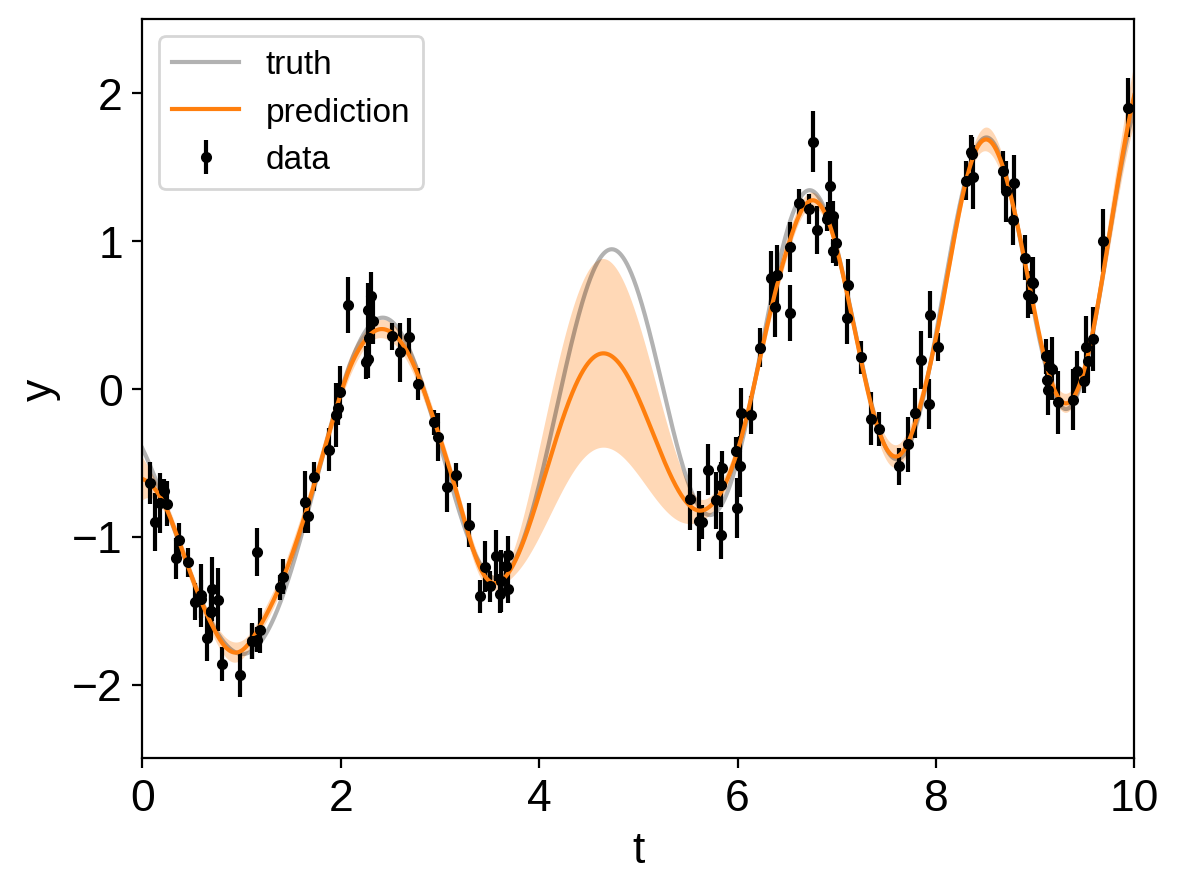

In [7]:
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(true_t, mu, color="C1", label="prediction")

plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

Now we can sample this model using PyMC3.
There are strong covariances between the parameters so we'll use the custom :func:`exoplanet.get_dense_nuts_step` to fit for these covariances during burn-in.

In [8]:
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_Q, w2, w1, S2, S1, mean]


Sampling 2 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 6/8000 [00:00<02:36, 51.00draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/8000 [00:00<03:36, 36.96draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 12/8000 [00:00<04:37, 28.74draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 14/8000 [00:00<05:51, 22.75draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 20/8000 [00:00<04:46, 27.87draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 28/8000 [00:00<03:52, 34.31draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/8000 [00:00<03:15, 40.65draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 44/8000 [00:01<02:59, 44.36draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 50/8000 [00:01<03:02, 43.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 55/8000 [00:01<03:03, 43.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 63/8000 [00:01<02:47, 47.45draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 69/8000 [00:01<02:39, 49.77draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 75/8000 [00:01<02:34, 51.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 85/8000 [00:01<02:12, 59.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 97/8000 [00:01<01:52, 70.43draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 106/8000 [00:01<01:49, 72.10draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 118/8000 [00:02<01:36, 81.35draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 128/8000 [00:02<01:50, 71.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 139/8000 [00:02<01:41, 77.60draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 148/8000 [00:02<01:43, 75.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 163/8000 [00:02<01:28, 88.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 175/8000 [00:02<01:22, 95.29draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 186/8000 [00:02<01:24, 92.60draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 206/8000 [00:02<01:10, 109.78draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 229/8000 [00:02<00:59, 129.95draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 250/8000 [00:03<00:52, 146.28draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 274/8000 [00:03<00:46, 164.79draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 300/8000 [00:03<00:41, 184.56draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 329/8000 [00:03<00:37, 207.00draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 368/8000 [00:03<00:31, 238.73draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 403/8000 [00:03<00:28, 263.57draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 435/8000 [00:03<00:27, 275.32draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 471/8000 [00:03<00:25, 292.20draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 503/8000 [00:03<00:25, 296.17draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 542/8000 [00:04<00:23, 317.03draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 576/8000 [00:04<00:22, 323.57draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 614/8000 [00:04<00:22, 334.84draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 649/8000 [00:04<00:21, 334.42draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 686/8000 [00:04<00:21, 343.74draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 721/8000 [00:04<00:22, 330.29draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 756/8000 [00:04<00:21, 330.76draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 793/8000 [00:04<00:21, 341.07draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 829/8000 [00:04<00:20, 345.34draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 866/8000 [00:04<00:20, 350.58draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 902/8000 [00:05<00:20, 341.78draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 939/8000 [00:05<00:20, 349.64draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 975/8000 [00:05<00:19, 351.30draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1011/8000 [00:05<00:19, 351.80draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1047/8000 [00:05<00:19, 351.92draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1083/8000 [00:05<00:19, 347.45draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1120/8000 [00:05<00:19, 352.05draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1156/8000 [00:05<00:19, 352.34draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1192/8000 [00:05<00:19, 349.82draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1228/8000 [00:05<00:19, 350.04draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1264/8000 [00:06<00:19, 344.63draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1302/8000 [00:06<00:19, 351.61draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1338/8000 [00:06<00:19, 350.26draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1374/8000 [00:06<00:19, 340.11draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1409/8000 [00:06<00:20, 328.25draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1447/8000 [00:06<00:19, 340.39draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 1482/8000 [00:06<00:19, 342.76draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1517/8000 [00:06<00:19, 338.85draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1552/8000 [00:06<00:19, 333.76draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 1586/8000 [00:07<00:19, 332.38draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1620/8000 [00:07<00:19, 334.45draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1657/8000 [00:07<00:18, 344.12draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1692/8000 [00:07<00:18, 345.42draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1728/8000 [00:07<00:18, 347.18draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1764/8000 [00:07<00:18, 345.81draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1799/8000 [00:07<00:18, 338.13draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1833/8000 [00:07<00:18, 335.75draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1870/8000 [00:07<00:17, 345.23draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1905/8000 [00:07<00:18, 336.13draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1939/8000 [00:08<00:18, 335.54draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 1979/8000 [00:08<00:17, 348.35draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 2015/8000 [00:08<00:17, 347.78draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2050/8000 [00:08<00:17, 348.38draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2085/8000 [00:08<00:16, 348.83draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 2120/8000 [00:08<00:17, 342.15draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2156/8000 [00:08<00:16, 347.26draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2192/8000 [00:08<00:16, 349.51draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2228/8000 [00:08<00:16, 349.61draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2263/8000 [00:09<00:16, 349.03draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2300/8000 [00:09<00:16, 354.90draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2340/8000 [00:09<00:15, 365.01draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 2377/8000 [00:09<00:15, 354.34draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 2417/8000 [00:09<00:15, 364.85draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2454/8000 [00:09<00:16, 342.72draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2489/8000 [00:09<00:16, 340.29draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2526/8000 [00:09<00:15, 347.55draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2563/8000 [00:09<00:15, 353.04draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2599/8000 [00:09<00:15, 344.19draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2635/8000 [00:10<00:15, 347.38draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2673/8000 [00:10<00:15, 354.20draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2710/8000 [00:10<00:14, 355.50draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2746/8000 [00:10<00:14, 353.75draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 2782/8000 [00:10<00:14, 355.17draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 2819/8000 [00:10<00:14, 358.92draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2855/8000 [00:10<00:14, 350.71draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2891/8000 [00:10<00:14, 353.19draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2927/8000 [00:10<00:14, 353.77draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2963/8000 [00:10<00:14, 352.82draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2999/8000 [00:11<00:14, 350.41draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3035/8000 [00:11<00:14, 349.65draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3071/8000 [00:11<00:14, 349.65draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3106/8000 [00:11<00:14, 345.33draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3141/8000 [00:11<00:14, 334.58draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 3176/8000 [00:11<00:14, 337.45draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 3212/8000 [00:11<00:13, 342.66draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3248/8000 [00:11<00:13, 343.42draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3287/8000 [00:11<00:13, 353.59draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3323/8000 [00:12<00:13, 350.14draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3359/8000 [00:12<00:13, 345.72draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3395/8000 [00:12<00:13, 345.33draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3430/8000 [00:12<00:13, 342.99draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3465/8000 [00:12<00:13, 342.15draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3500/8000 [00:12<00:13, 341.01draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3535/8000 [00:12<00:13, 340.28draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 3571/8000 [00:12<00:12, 343.58draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 3606/8000 [00:12<00:12, 340.29draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3641/8000 [00:12<00:13, 333.51draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3678/8000 [00:13<00:12, 342.89draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 3713/8000 [00:13<00:12, 339.75draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3749/8000 [00:13<00:12, 344.43draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3786/8000 [00:13<00:12, 348.21draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3823/8000 [00:13<00:11, 349.52draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3859/8000 [00:13<00:11, 352.09draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 3895/8000 [00:13<00:11, 348.08draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 3931/8000 [00:13<00:11, 346.52draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 3966/8000 [00:13<00:11, 346.86draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 4001/8000 [00:13<00:11, 347.00draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 4037/8000 [00:14<00:11, 349.66draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 4072/8000 [00:14<00:11, 348.97draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 4107/8000 [00:14<00:11, 346.05draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4142/8000 [00:14<00:11, 340.03draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4178/8000 [00:14<00:11, 343.30draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4214/8000 [00:14<00:10, 347.51draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4249/8000 [00:14<00:10, 346.65draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 4284/8000 [00:14<00:10, 346.98draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 4320/8000 [00:14<00:10, 346.60draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 4356/8000 [00:15<00:10, 350.47draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 4393/8000 [00:15<00:10, 355.60draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 4429/8000 [00:15<00:10, 348.47draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 4466/8000 [00:15<00:10, 349.30draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 4501/8000 [00:15<00:10, 346.85draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 4536/8000 [00:15<00:10, 343.49draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 4571/8000 [00:15<00:10, 342.04draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 4606/8000 [00:15<00:10, 336.14draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 4641/8000 [00:15<00:09, 337.28draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 4675/8000 [00:15<00:09, 336.66draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 4709/8000 [00:16<00:10, 328.39draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 4743/8000 [00:16<00:09, 330.82draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 4779/8000 [00:16<00:09, 338.46draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 4813/8000 [00:16<00:09, 336.99draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 4847/8000 [00:16<00:09, 335.40draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 4882/8000 [00:16<00:09, 336.21draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 4918/8000 [00:16<00:09, 341.45draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 4954/8000 [00:16<00:08, 344.40draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 4989/8000 [00:16<00:08, 338.09draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 5024/8000 [00:16<00:08, 340.86draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 5062/8000 [00:17<00:08, 348.71draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 5100/8000 [00:17<00:08, 353.84draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 5136/8000 [00:17<00:08, 353.31draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 5172/8000 [00:17<00:08, 348.24draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 5210/8000 [00:17<00:07, 355.02draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 5247/8000 [00:17<00:07, 357.01draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 5283/8000 [00:17<00:07, 352.95draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 5319/8000 [00:17<00:07, 348.37draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 5354/8000 [00:17<00:07, 344.16draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 5390/8000 [00:18<00:07, 347.46draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 5425/8000 [00:18<00:07, 343.59draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 5460/8000 [00:18<00:07, 345.16draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 5495/8000 [00:18<00:07, 341.20draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 5530/8000 [00:18<00:07, 341.63draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 5566/8000 [00:18<00:07, 344.25draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 5602/8000 [00:18<00:06, 347.60draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 5637/8000 [00:18<00:07, 336.07draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 5673/8000 [00:18<00:06, 340.92draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 5708/8000 [00:18<00:06, 343.12draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 5746/8000 [00:19<00:06, 352.63draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 5783/8000 [00:19<00:06, 354.94draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 5819/8000 [00:19<00:06, 350.72draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 5855/8000 [00:19<00:06, 343.96draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 5893/8000 [00:19<00:05, 353.75draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 5929/8000 [00:19<00:05, 349.18draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 5965/8000 [00:19<00:05, 348.76draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 6000/8000 [00:19<00:05, 348.05draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 6036/8000 [00:19<00:05, 348.43draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 6071/8000 [00:19<00:05, 347.90draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 6106/8000 [00:20<00:05, 347.74draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 6141/8000 [00:20<00:05, 344.04draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 6178/8000 [00:20<00:05, 350.82draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 6216/8000 [00:20<00:05, 356.37draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 6253/8000 [00:20<00:04, 355.92draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 6289/8000 [00:20<00:04, 355.04draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 6325/8000 [00:20<00:04, 350.28draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 6361/8000 [00:20<00:04, 349.67draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 6396/8000 [00:20<00:04, 346.23draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 6431/8000 [00:21<00:04, 339.89draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 6466/8000 [00:21<00:04, 339.15draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 6502/8000 [00:21<00:04, 342.48draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 6537/8000 [00:21<00:04, 338.07draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 6572/8000 [00:21<00:04, 340.97draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 6607/8000 [00:21<00:04, 339.04draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 6643/8000 [00:21<00:03, 344.49draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 6679/8000 [00:21<00:03, 348.25draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 6714/8000 [00:21<00:03, 332.38draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 6749/8000 [00:21<00:03, 335.05draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 6786/8000 [00:22<00:03, 343.13draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 6821/8000 [00:22<00:03, 339.79draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 6857/8000 [00:22<00:03, 344.32draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 6895/8000 [00:22<00:03, 353.84draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 6931/8000 [00:22<00:03, 352.08draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 6967/8000 [00:22<00:02, 344.70draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 7002/8000 [00:22<00:02, 344.28draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 7037/8000 [00:22<00:02, 343.41draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 7072/8000 [00:22<00:02, 341.51draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 7107/8000 [00:23<00:02, 336.15draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 7142/8000 [00:23<00:02, 339.74draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 7179/8000 [00:23<00:02, 346.73draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 7215/8000 [00:23<00:02, 348.05draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 7251/8000 [00:23<00:02, 350.44draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 7288/8000 [00:23<00:01, 356.08draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 7324/8000 [00:23<00:01, 349.45draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 7360/8000 [00:23<00:01, 348.52draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 7395/8000 [00:23<00:01, 347.95draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 7430/8000 [00:23<00:01, 346.55draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 7468/8000 [00:24<00:01, 355.05draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 7505/8000 [00:24<00:01, 359.10draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 7541/8000 [00:24<00:01, 351.32draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 7577/8000 [00:24<00:01, 347.75draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 7612/8000 [00:24<00:01, 347.64draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 7647/8000 [00:24<00:01, 347.09draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 7684/8000 [00:24<00:00, 351.90draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 7720/8000 [00:24<00:00, 349.31draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 7755/8000 [00:24<00:00, 339.67draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 7790/8000 [00:24<00:00, 337.35draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 7825/8000 [00:25<00:00, 338.44draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 7861/8000 [00:25<00:00, 343.90draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 7897/8000 [00:25<00:00, 346.16draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 7932/8000 [00:25<00:00, 342.28draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 7967/8000 [00:25<00:00, 320.47draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:25<00:00, 264.41draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:25<00:00, 311.51draws/s]

Now we can compute the standard PyMC3 convergence statistics (using `pymc3.summary`) and make a trace plot (using `pymc3.traceplot`).

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.019,0.444,-0.778,0.855,0.007,0.007,4411.0,1981.0,4477.0,2975.0,1.0
S1,0.986,0.626,0.241,1.974,0.011,0.008,3423.0,3038.0,4644.0,2904.0,1.0
S2,0.271,0.118,0.098,0.495,0.002,0.001,4380.0,3626.0,4875.0,3041.0,1.0
w1,0.971,0.239,0.543,1.403,0.004,0.003,4426.0,4039.0,4536.0,3002.0,1.0
w2,3.198,0.207,2.805,3.592,0.003,0.002,4359.0,4359.0,4613.0,2545.0,1.0
log_Q,1.807,0.351,1.182,2.302,0.005,0.004,4667.0,4667.0,4385.0,2399.0,1.0


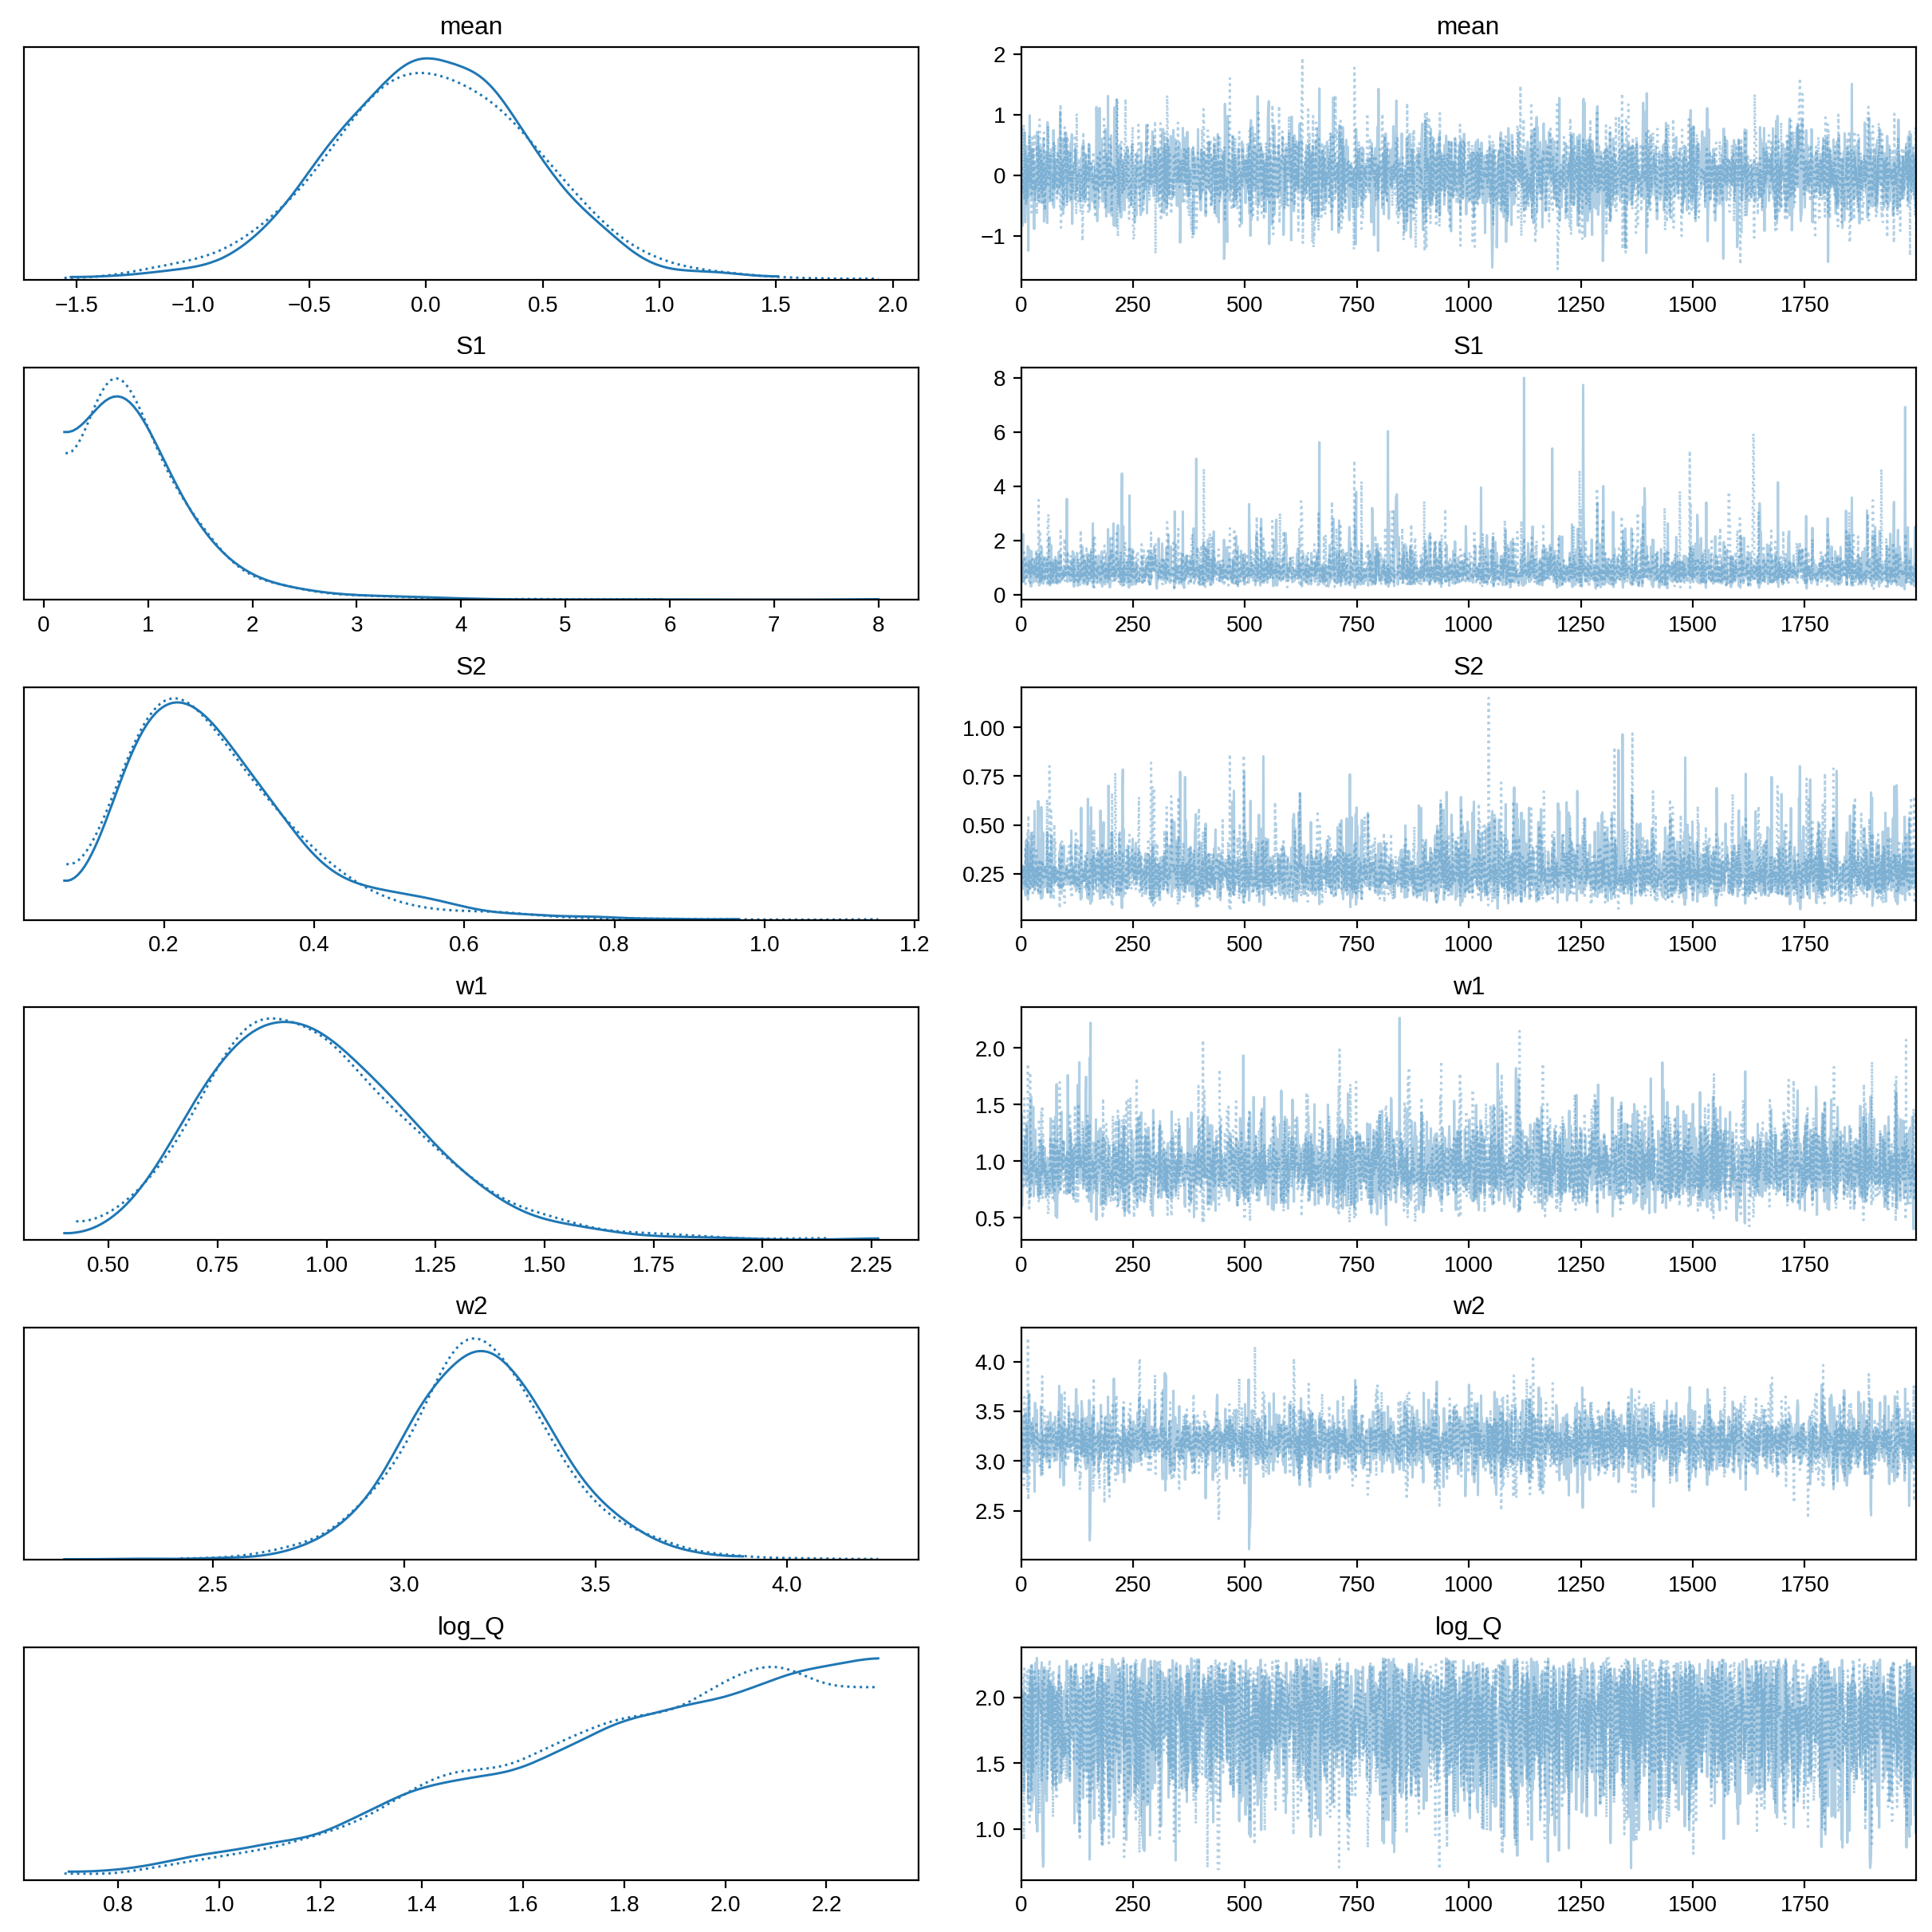

In [9]:
pm.traceplot(trace)
pm.summary(trace)

That all looks pretty good, but I like to make two other results plots: (1) a [corner plot](https://corner.readthedocs.io) and (2) a posterior predictive plot.

The corner plot is easy using `pymc3.trace_to_dataframe` and I find it useful for understanding the covariances between parameters when debugging.

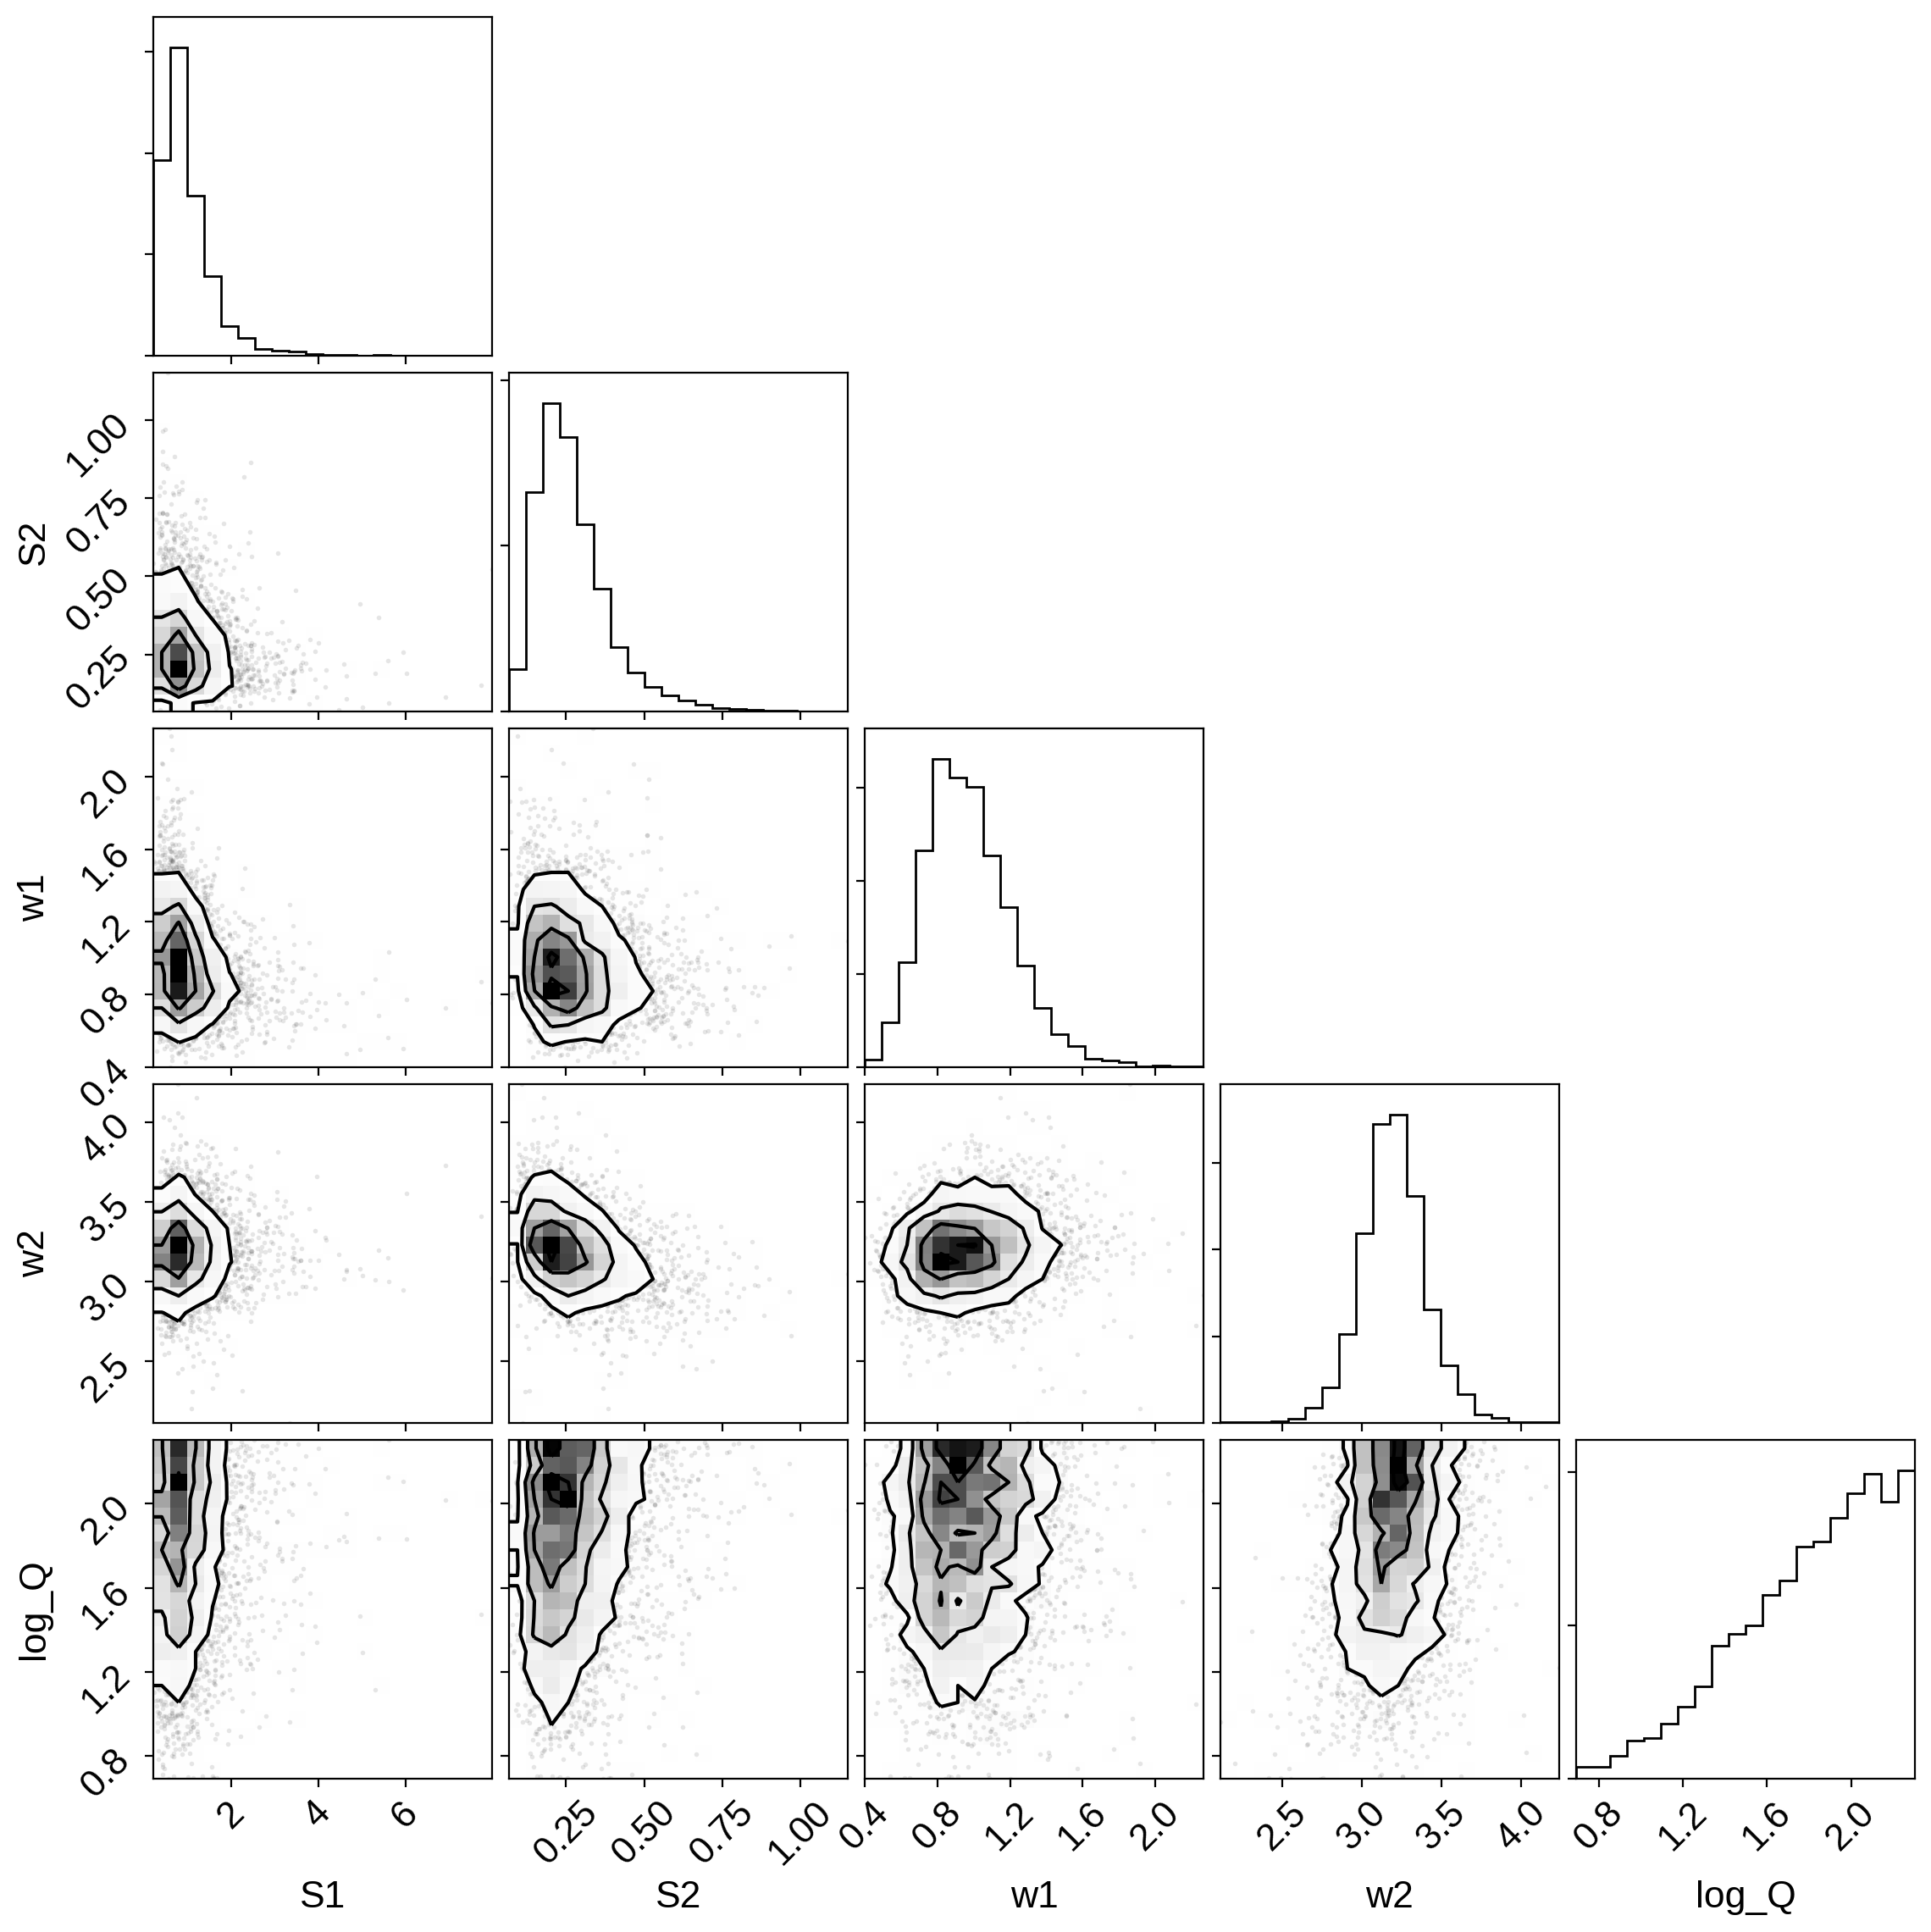

In [10]:
import corner

samples = pm.trace_to_dataframe(
    trace, varnames=["S1", "S2", "w1", "w2", "log_Q"]
)
_ = corner.corner(samples)

The "posterior predictive" plot that I like to make isn't the same as a "posterior predictive check" (which can be a good thing to do too).
Instead, I like to look at the predictions of the model in the space of the data.
We could have saved these predictions using a `pymc3.Deterministic` distribution, but that adds some overhead to each evaluation of the model so instead, we can use :func:`exoplanet.utils.get_samples_from_trace` to loop over a few random samples from the chain and then the :func:`exoplanet.eval_in_model` function to evaluate the prediction just for those samples.

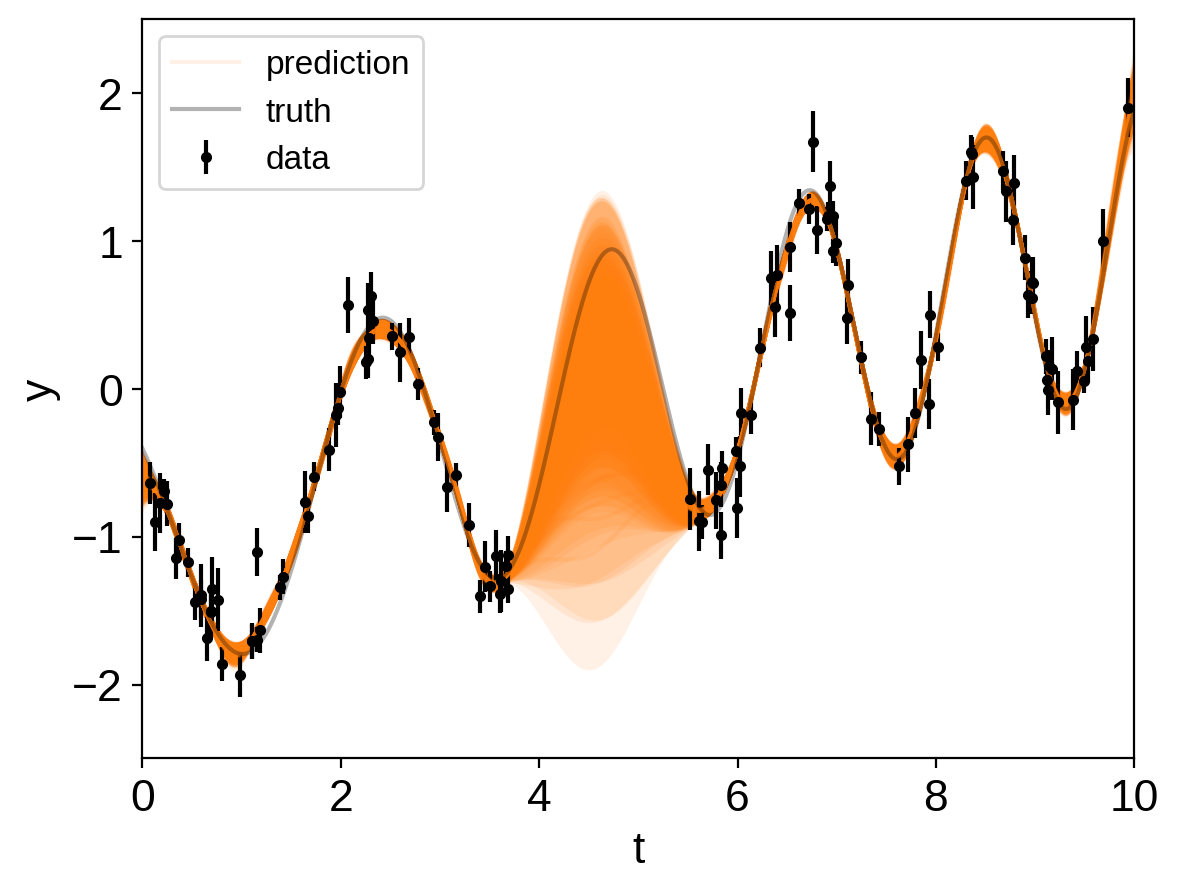

In [11]:
# Generate 50 realizations of the prediction sampling randomly from the chain
N_pred = 50
pred_mu = np.empty((N_pred, len(true_t)))
pred_var = np.empty((N_pred, len(true_t)))
with model:
    pred = gp.predict(true_t, return_var=True, predict_mean=True)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=N_pred)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

# Plot the predictions
for i in range(len(pred_mu)):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    label = None if i else "prediction"
    art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.1)
    art.set_edgecolor("none")
    plt.plot(true_t, mu, color="C1", label=label, alpha=0.1)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.legend(fontsize=12, loc=2)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
